In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


In [37]:
torch.cuda.mem_get_info()

(3522586215, 4294705152)

In [38]:
from d2l import torch as d2l

In [39]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

In [40]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

In [41]:
import matplotlib.pyplot as plt


In [42]:
data.save_hyperparameters?

Signature: data.save_hyperparameters(ignore=[])
Docstring:
Save function arguments into class attributes.

Defined in :numref:`sec_utils`
File:      c:\users\justm\onedrive\desktop\ml-practice\.venv\lib\site-packages\d2l\torch.py
Type:      method

In [43]:
import random
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [44]:

@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                    shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [45]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [46]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [47]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [48]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [49]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [50]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

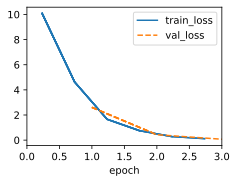

In [51]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [52]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1250, -0.2681])
error in estimating b: tensor([0.2538])


In [53]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [54]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

In [55]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [56]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [58]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0030, -0.0102])
error in estimating b: tensor([0.0071])


In [62]:
import torchvision
from torchvision import transforms
class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [63]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val), data.train[0][0].shape

(60000, 10000, torch.Size([1, 32, 32]))

In [64]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
            'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [65]:
data.text_labels([0, 1, 2])

['t-shirt', 'trouser', 'pullover']

In [80]:
import torch.utils.data
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    self.num_workers = 2
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                    num_workers=self.num_workers)

In [81]:

import time
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'10.06 sec'

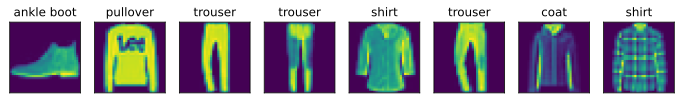

In [69]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [82]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [83]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

In [84]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [89]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True).shape, X.sum(0, keepdim=False).shape

(torch.Size([1, 3]), torch.Size([3]))

In [91]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [4]:
import torch
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [17]:
X = torch.arange(8, dtype = torch.float32).reshape((2, 4))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  6.],
        [ 8., 10.,  0., 14.]])
dropout_p = 1: tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [18]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X

In [20]:
# We need to give the shared layer a name so that we can refer to its
# parameters
import torch.nn as nn
shared = nn.LazyLinear(3)
net = nn.Sequential(nn.LazyLinear(3), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same

print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True])
tensor([True, True, True])


In [22]:
list(net.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.4856,  0.2209,  0.2062,  0.3914],
          [ 0.2297,  0.2011, -0.3477,  0.2613],
          [ 0.0456,  0.0311, -0.4632,  0.1784]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([ 0.4708, -0.1727,  0.2354], requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[ 1.0000e+02, -5.3025e-01, -5.0535e-01],
          [ 2.0671e-01, -9.9863e-03,  5.3676e-01],
          [ 5.3173e-01,  1.9077e-01, -5.2797e-01]], requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([-0.4294, -0.4782, -0.3348], requires_grad=True)),
 ('6.weight',
  Parameter containing:
  tensor([[-0.1348,  0.2939, -0.0408]], requires_grad=True)),
 ('6.bias',
  Parameter containing:
  tensor([0.3926], requires_grad=True))]

In [23]:
def my_init(module):
    if type(module) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in module.named_parameters()][0])
        nn.init.uniform_(module.weight, -10, 10)
        module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([3, 4])
Init weight torch.Size([3, 3])
Init weight torch.Size([1, 3])


tensor([[-6.5722,  0.0000,  8.6635,  0.0000],
        [-0.0000, -8.5867, -6.5797,  0.0000]], grad_fn=<SliceBackward0>)

In [24]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

In [25]:
torch.tensor([1, 2, 3]).cuda()

tensor([1, 2, 3], device='cuda:0')